# Introduction
<!-- notice we only need to focus on the implementation detail in this file -->
1. Public Data (just describe a bit and tell them to check another file)
2. Private Data (combine the original and reversed times and save to main path, also need to explain a bit how the data was obtained)
3. Survey Data (explain)
- to mode percent
- to commuting flow
4. Parameter Estimation
- combine neighborhoods to counties
- estimate gamma and delta
- estimate epsilon times k

# Public Data
The public transit data is mainly retrieved from the Transport Data eXchange platform, hosted by the Taiwan Ministry of Transportation and Communication (MOTC). For travel data not available at the TDX platform, we use walking data from OSRM and Google Maps routing service instead.

Please refer to the public_data_procedure.ipynb for the step-by-step procedure.

# Private Data
We define the routing result for car from OSRM as our private travel data. We have the back and forth travel time recorded in separate files, thus we combine them for later analysis.

In [ ]:
import pandas as pd
import os

FOLDER_PRIVATE_RAW = 'JJinTP_data_TW/car_data/Raw/'
FOLDER_PRIVATE_MAIN = 'JJinTP_data_TW/car_data/Main/'

keep_cols = ['id_orig', 'id_dest', 'duration']

car_data1 = pd.read_csv(
    os.path.join(FOLDER_PRIVATE_RAW, 'travel_driving_20241206134817.csv'),
    usecols=keep_cols, dtype={'id_orig': 'str', 'id_dest': 'str'}
)
car_data2 = pd.read_csv(
    os.path.join(FOLDER_PRIVATE_RAW, 'travel_driving_reverse_20250320165625.csv'),
    usecols=keep_cols, dtype={'id_orig': 'str', 'id_dest': 'str'}
)

# since the ids in the two dataframes are in reverse order,
# we could join them by reversing the ids in one of the dataframes
car_data1 = car_data1.rename(
    columns={'id_orig': 'A_villcode', 'id_dest': 'B_villcode', 'duration': 'AB_travel_time'}
)
car_data2 = car_data2.rename(
    columns={'id_orig': 'B_villcode', 'id_dest': 'A_villcode', 'duration': 'BA_travel_time'}
)
private_data = car_data1.merge(car_data2, on=['A_villcode', 'B_villcode'], how='left')

print("Should be no empty:")
na_cnt = private_data['BA_travel_time'].isnull().sum()
print(f"There are {na_cnt} empty values in BA_travel_time")

# save the data
private_data.to_csv(
    os.path.join(FOLDER_PRIVATE_MAIN, 'private_travel_time.csv'),
    index=False
)
print("Private data saved.")


Should be no empty:
There are 0 empty values in BA_travel_time
Private data saved.


# Survey Data
The survey was done by Taiwan MOTC, sampled from all of the administrative cities, about the daily transportation mode used by the public. We used the calibration data to extract the counties of our interest. 

This survey data would be used as the possibility of usage of transit modes and the commuting flow.

In [1]:
import helper

FOLDER_SURVEY_RAW = 'JJinTP_data_TW/survey_data/Raw/'
FOLDER_SURVEY_SCRATCH = 'JJinTP_data_TW/survey_data/Scratch/'
FOLDER_SURVEY_MAIN = 'JJinTP_data_TW/survey_data/Main/'

FILE_CALIB = "JJinTP_data_TW/calibration_data_TP.csv"

htc = helper.Helper_travel_cost(
    calib_path=FILE_CALIB
)

# Survey data
years = list(range(98, 106))  # ROC 98-105 = year 2009-2016
htc.process_survey(
    years=years,
    survey_raw=FOLDER_SURVEY_RAW,
    survey_scratch=FOLDER_SURVEY_SCRATCH,
    out_path=FOLDER_SURVEY_MAIN
)  # creates public_mode_cnt.csv and private_mode_cnt.csv

# Parameter Estimation
There will be two steps of estimation.
1. estimate $\gamma$ and $\delta$
2. estimate $\varepsilon k$

Before estimation, there are several steps of preparation:
1. merge neighborhood-level travel time to county-level
2. turn the data into matrix for $\gamma$ and $\delta$ estimation
3. 

In [1]:
# ======= Preparation =======
import pandas as pd
import os
import helper

# File and Folder settings
FOLDER_PUBLIC_MAIN = 'JJinTP_data_TW/public_data/Main/'
FOLDER_PRIVATE_MAIN = 'JJinTP_data_TW/car_data/Main/'

FILE_CALIB = "JJinTP_data_TW/calibration_data_TP.csv"

# Read travel time data
public_data = pd.read_csv(
    os.path.join(FOLDER_PUBLIC_MAIN, 'public_travel_time_revised.csv'),
    dtype={'A_villcode': 'str', 'B_villcode': 'str'}
)
private_data = pd.read_csv(
    os.path.join(FOLDER_PRIVATE_MAIN, 'private_travel_time.csv'),
    dtype={'A_villcode': 'str', 'B_villcode': 'str'}
)

# Neighborhoods to counties (travel time)
htc = helper.Helper_travel_cost(
    calib_path=FILE_CALIB
)

htc.neighborhood_to_county(
    mode='public',  # just for out file naming
    in_path=FOLDER_PUBLIC_MAIN,
    out_path=FOLDER_PUBLIC_MAIN
)  # saved as public_county_tt_mat.csv
htc.neighborhood_to_county(
    mode='private',
    in_path=FOLDER_PRIVATE_MAIN,
    out_path=FOLDER_PRIVATE_MAIN
)  # saved as private_county_tt_mat.csv

### Estimation: $\gamma$ and $\delta$
Note that $\gamma$ stands for fixed costs and $\delta$ stands for variable costs of using transit mode.

In [2]:
# ======= Estimation: gamma and delta =======
import os
import pandas as pd
import travel_cost as tc

# File and Folder settings
FOLDER_PUBLIC_MAIN = 'JJinTP_data_TW/public_data/Main/'
FOLDER_PRIVATE_MAIN = 'JJinTP_data_TW/car_data/Main/'
FOLDER_SURVEY_MAIN = 'JJinTP_data_TW/survey_data/Main/'

# Read data
pub_mode_cnt = pd.read_csv(os.path.join(FOLDER_SURVEY_MAIN, 'public_mode_cnt.csv'))
pri_mode_cnt = pd.read_csv(os.path.join(FOLDER_SURVEY_MAIN, 'private_mode_cnt.csv'))
pub_tt_mat = pd.read_csv(os.path.join(FOLDER_PUBLIC_MAIN, 'public_county_tt_mat.csv'))
pri_tt_mat = pd.read_csv(os.path.join(FOLDER_PRIVATE_MAIN, 'private_county_tt_mat.csv'))

# old data to test
pub_tt_mat = pd.read_csv(os.path.join('JJinTP_data_TW/archive/', 'public_town_travel_mat.csv'))
# pri_tt_mat = pd.read_csv(os.path.join('JJinTP_data_TW/archive/', 'private_town_travel_mat.csv'))


# Prep
counties = pub_tt_mat.columns  # the list of county codes
pub_tt_mat = pub_tt_mat.values / 60  # convert to minutes
pri_tt_mat = pri_tt_mat.values / 60

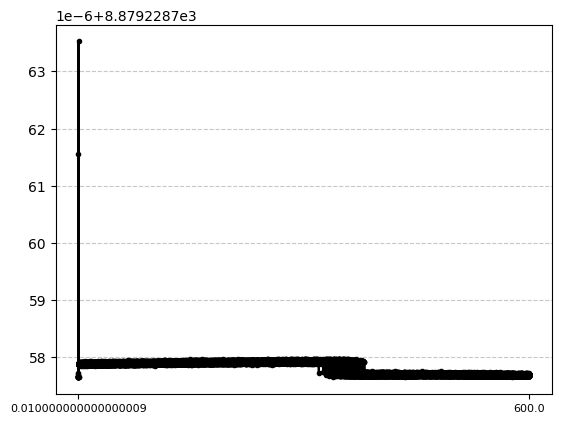

In [7]:
# Manual search for 'global' minimum
# test on 0.01 ~ 1
step_setting = {
    "step_size": 0.01,
    "step_method": '+'
}

opt = tc.manual_minimize(
    init_val=1,
    bounds=[0.01, 600],  # number higher than 650 will cause problem
    public_travel_mat=pub_tt_mat,
    private_travel_mat=pri_tt_mat,
    public_transport_cnt_mat=pub_mode_cnt.values,
    private_transport_cnt_mat=pri_mode_cnt.values,
    show_plot=True,
    **step_setting
)

In [ ]:
# Travel cost and save the melted matrix
from helper import Utils
import pandas as pd

# gamma_public, gamma_private, delta_public, delta_private
# optimal_params = opt['params']  # [0.32878638, 0, 0.02145531, 0.07643203]

optimal_params = [0.32878638, 0, 0.02145531, 0.07643203]

nbh_travel_cost = tc.travel_cost(
    optimal_params,
    public_travel_mat=pub_tt_mat,
    private_travel_mat=pri_tt_mat
)

# melt the matrix
util = Utils()
nbh_travel_cost_melted = util.melt_mat(
    mat=nbh_travel_cost,
    index_list=counties,
    is_same=False,
    keep_diag=True
)
nbh_travel_cost_melted.columns = ['A_TOWNCODE', 'B_TOWNCODE', 'AB_travel_cost', 'BA_travel_cost']

# output for manual check (since output as .dta is hard to check)
out_fpath = 'JJinTP_data_TW/travel_cost.csv'
if os.path.exists(out_fpath):
    print("Please remove the file first.")
else:
    nbh_travel_cost_melted.to_csv(out_fpath, index=False)

### Estimation: $\varepsilon k$
We will do this part in Stata, so save the required files as ".dta".

In [ ]:
# travel cost data
nbh_travel_cost_melted.to_stata(
    'JJinTP_data_TW/for_stata/travel_cost.dta'
)

# commuting flow
# TODO: not sure if the denominator is aggregated for entire file or just that county
cf = pd.read_csv(
    os.path.join(FOLDER_SURVEY_MAIN, 'commuting_flow.csv'),
    dtype={'A_TOWNCODE': 'str', 'B_TOWNCODE': 'str'}
)
tot_cnt = sum(cf['count'])
cf['count'] = cf['count'] / tot_cnt

cf.to_stata(
    'JJinTP_data_TW/for_stata/commuting_flow.dta'
)

# This completes the whole travel cost procedure.
<!--jupyter nbconvert --to html travel_cost_procedure.ipynb -->

In [4]:
# # Revised travel time data with the old data
# keep_cols = ['A_villcode', 'B_villcode', 'AB_travel_time', 'BA_travel_time']
# old_data = pd.read_csv(
#     os.path.join('JJinTP_data_TW/archive/', 'public_travel_time.csv'),
#     usecols=keep_cols
# )
# new_data = pd.read_csv(
#     os.path.join('JJinTP_data_TW/public_data/Main/', 'public_travel_time.csv'),
#     usecols=keep_cols
# )

# check = new_data.merge(
#     old_data.rename(columns={'AB_travel_time': 'AB_travel_time_old', 'BA_travel_time': 'BA_travel_time_old'}),
#     on=['A_villcode', 'B_villcode'], how='left'
# )

# # for those having (same A->B and B->A) and the time is less than 1800 in the new data,
# # if data in the old columns are smaller, fill with the old data
# cond = (check['AB_travel_time'] == check['BA_travel_time']) &\
#        (check['AB_travel_time'] < 1800) &\
#        ((check['AB_travel_time'] > check['AB_travel_time_old']) |\
#         (check['BA_travel_time'] > check['BA_travel_time_old']))
# check[['AB_travel_time_new', 'BA_travel_time_new']] = check[['AB_travel_time', 'BA_travel_time']]
# check.loc[cond, ['AB_travel_time_new', 'BA_travel_time_new']] = check.loc[cond, ['AB_travel_time_old', 'BA_travel_time_old']].values

# check = check.drop(columns=['AB_travel_time', 'BA_travel_time', 'AB_travel_time_old', 'BA_travel_time_old'])
# check = check.rename(columns={'AB_travel_time_new': 'AB_travel_time', 'BA_travel_time_new': 'BA_travel_time'})
# check.to_csv('JJinTP_data_TW/public_data/Main/public_travel_time_revised.csv', index=False)

In [5]:
# The following code is for replacing transit time with walking time

# import helper
# import os

# # ======== File and Folder settings ========
# FOLDER_PUBLIC_RAW = 'JJinTP_data_TW/public_data/Raw/'
# FOLDER_PUBLIC_SCRATCH = 'JJinTP_data_TW/public_data/Scratch/'
# FOLDER_PUBLIC_MAIN = 'JJinTP_data_TW/public_data/Main/'

# # The calibration data keeps only the counties we need
# FILE_CALIB = "JJinTP_data_TW/calibration_data_TP.csv"

# # This is the full list of all counties in the Taipei Metropolitan,
# # with the longitude and latitude of the county centroids
# FILE_VILL_CENTROID = "JJinTP_data_TW/village_centroid_TP.csv"

# # The walking data by OSRM
# FILE_WALKING = os.path.join(FOLDER_PUBLIC_MAIN, 'travel_walking.csv')

# hpt = helper.Helper_public_travel(
#     calib_fpath=FILE_CALIB,
#     centroid_path=FILE_VILL_CENTROID,
#     walk_fpath=FILE_WALKING,
#     public_merged_fname='merged_public.csv'
# )

# hpt.update_with_walk(
#     final_public_fpath=os.path.join(FOLDER_PUBLIC_MAIN, "public_travel_time_revised.csv"),
# )